In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pandas as pd
import scipy as sci
from scipy import interpolate
import seaborn
seaborn.set_style('darkgrid', {'legend.frameon':True})


## Files Needed:
- Paleomag_database.xlsx
- ERA40lat
- ERA40lon
- meanT
- meanP
- Onx3HeT 
- Sinx3HeT 
- Fenx3HeT
- Canx3HeT
- Mgnx3HeT
- Alnx3HeT
- a_values
- b_values
- basic_spectrum
- c_values
- ground_level_spectrum
- thermal_neutron_spectrum
- basic_spectrum_protons
- primary_spectrum
- secondary_spectrum 
- h_values_protons
- Opx3HeT
- Sipx3HeT
- Fepx3HeT
- Capx3HeT
- Mgpx3HeT
- Alpx3HeT

## User Inputs

In [2]:
site_lat = 40
site_lon = 50 #correct for negative longitudes in ERA40 analysis
therm = False #does the user want the therm criteria (specified paleomag data)? Used in paleomag section
altitude = 1000 #user input, in meters above sea level, for pressure correction. Used in pressure section
stdatm = 1 #user inputs 1 for standard, 0 for ERA40. Used in pressure section
w = 0.06; # water content, from 0-1. Used in production rates calculation. 0.06 is standard, see LSD.
system = 1 #1 for qtz, 2 for cpx, 3 for olivine. Used in production rates calculation

## Paleointensity Section
- Cell 1: import custom paleomag (IAGA + Geomagia) database. Need excel file for this to run. Compiled by Katie Bristol
- Cell 2: generates paleolatitude (variational) vector
- Cell 3: Code will drop any data points beyond 70 Ma.
    - This cell also includes any criteria specifications
    - NOTE: if you change therm from true to false, have to run notebook from beginning. 
- Cell 5: assigns bin_names in 5 myr increments to the dataset. 
- Cell 6: calculates mean VDM's for each 5 Myr bin, while also printing out how many datapoints were used to calculate this mean.

In [3]:
#CELL 1
Paleomag_database = pd.read_excel('Paleomag_database.xlsx') #excel sheet with all pmag data. 0-70 Ma, all criteria

In [56]:
#CELL 2
time = [0.05,5,10,15,20,25,30,35,40,45,50,55,60,65,70] #will report paleolatitude values from 0-70 Million years ago, in 5 Myr increments 
vals = [] #storage for pmagpy data 
for i in time:
    data=['NA',site_lat, site_lon,i] #specify plate, lat/lon that was input above
    pmag.apwp(data, print_results = True) #change to true if you want to see the output
    vals.append(pmag.apwp(data))
#plate : [NA, SA, AF, IN, EU, AU, ANT, GL]
#                NA : North America
#                SA : South America
#                AF : Africa
#                IN : India
#                EU : Eurasia
#                AU : Australia
#                ANT: Antarctica
#                GL : Greenland
df = pd.DataFrame(vals) #create a dataframe with the pmagpy data
df.columns = ['Age', 'Paleolat', 'Dec','Inc','Pole_lat','Pole_Long'] #rename the columns
Paleolat = df['Paleolat'] #call paleolat whenever you want all the paleolatitudes for some time frame
Paleolat

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
    0.1    38.9     1.6    58.2    88.3    180.7

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
    5.0    37.7     4.5    57.1    85.8    171.9

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   10.0    37.6     5.7    57.0    84.9    166.1

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   15.0    37.2     7.6    56.7    83.5    162.6

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   20.0    37.0    10.7    56.4    81.1    156.7

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   25.0    36.7     8.5    56.1    82.5    163.9

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   30.0    32.2     8.2    51.6    79.8    187.2

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   35.0    32.8    10.6    52.2    78.9    176.9

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.
   40.0    33.5    13.2    52.9    77.6    167.7

 Age   Paleolat.   Dec.   Inc.   Pole_lat.  Pole_Long.


0     38.899529
1     37.683707
2     37.628359
3     37.247002
4     36.951728
5     36.651912
6     32.202302
7     32.809819
8     33.460488
9     34.332404
10    33.990601
11    31.210008
12    28.025348
13    24.487208
14    25.055694
Name: Paleolat, dtype: float64

In [5]:
#CELL 3
age_range = np.arange(0,70) #will remove data points beyond 70 Ma from paleomag database. 
Paleomag_database.drop(Paleomag_database[Paleomag_database['AGE'] < age_range[0]].index, inplace = True) 
Paleomag_database.drop(Paleomag_database[Paleomag_database['AGE'] > age_range[-1]].index, inplace = True)
#Paleomag_database

#Criteria evaluation
pd.set_option("display.max_rows", None, "display.max_columns", None) 

#here, the user will input what sort of criteria they want on the paleomag data used to calculate Rc
#True = therm parameters
#Note: weird spacing in title headers because of how Geomagia/IAGA databases are imported into excel file.
#If user imports excel file correctly, these lines should work properly. 
HeZ = Paleomag_database[Paleomag_database['IntM'] == '   HeZ       ' ].index
LTD_DHT_S = Paleomag_database[Paleomag_database['IntM'] == '   LTD-DHT-S ' ].index
M = Paleomag_database[Paleomag_database['IntM'] == '   M         ' ].index
MSPDp = Paleomag_database[Paleomag_database['IntM'] == '   MSPDp     ' ].index
ONR = Paleomag_database[Paleomag_database['IntM'] == '   ONR       ' ].index
S = Paleomag_database[Paleomag_database['IntM'] == '   S         ' ].index
ST = Paleomag_database[Paleomag_database['IntM'] == '   ST        ' ].index
SW = Paleomag_database[Paleomag_database['IntM'] == '   SW        ' ].index
TZ = Paleomag_database[Paleomag_database['IntM'] == '   TZ        ' ].index
Tminus = Paleomag_database[Paleomag_database['IntM'] == '   T-        ' ].index
W = Paleomag_database[Paleomag_database['IntM'] == '   W         ' ].index
WB = Paleomag_database[Paleomag_database['IntM'] == '   WB        ' ].index
WZ = Paleomag_database[Paleomag_database['IntM'] == '   WZ        ' ].index
Z = Paleomag_database[Paleomag_database['IntM'] == '   Z         ' ].index
Tv = Paleomag_database[Paleomag_database['IntM'] == '   Tv        ' ].index

if therm == True: #therm criteria, default is false.
    #the following lines index string values (criteria from excel sheet). 
    Paleomag_database.drop(HeZ, inplace=True)
    Paleomag_database.drop(LTD_DHT_S, inplace=True)
    Paleomag_database.drop(M, inplace=True)
    Paleomag_database.drop(MSPDp, inplace=True)
    Paleomag_database.drop(ONR, inplace=True)
    Paleomag_database.drop(S, inplace=True)
    Paleomag_database.drop(ST, inplace=True)
    Paleomag_database.drop(SW, inplace=True)
    Paleomag_database.drop(TZ, inplace=True)
    Paleomag_database.drop(Tv, inplace=True)
    Paleomag_database.drop(Tminus, inplace=True)
    Paleomag_database.drop(W, inplace=True)
    Paleomag_database.drop(WB, inplace=True)
    Paleomag_database.drop(WZ, inplace=True)
    Paleomag_database.drop(Z, inplace=True)

In [6]:
#CELL 5: Binning data for 5 Myr sets
bin_1 = Paleomag_database[Paleomag_database['AGE'] <= 0.05]
bin_2 = Paleomag_database[(Paleomag_database['AGE'] <= 5) & (Paleomag_database['AGE'] > 0.05)]
bin_3 = Paleomag_database[(Paleomag_database['AGE'] <= 10) & (Paleomag_database['AGE'] > 5)]
bin_4 = Paleomag_database[(Paleomag_database['AGE'] <= 15) & (Paleomag_database['AGE'] > 10)]
bin_5 = Paleomag_database[(Paleomag_database['AGE'] <= 20) & (Paleomag_database['AGE'] > 15)]
bin_6 = Paleomag_database[(Paleomag_database['AGE'] <= 25) & (Paleomag_database['AGE'] > 20)]
bin_7 = Paleomag_database[(Paleomag_database['AGE'] <= 30) & (Paleomag_database['AGE'] > 25)]
bin_8 = Paleomag_database[(Paleomag_database['AGE'] <= 35) & (Paleomag_database['AGE'] > 30)]
bin_9 = Paleomag_database[(Paleomag_database['AGE'] <= 40) & (Paleomag_database['AGE'] > 35)]
bin_10 = Paleomag_database[(Paleomag_database['AGE'] <= 45) & (Paleomag_database['AGE'] > 40)]
bin_11 = Paleomag_database[(Paleomag_database['AGE'] <= 50) & (Paleomag_database['AGE'] > 45)]
bin_12 = Paleomag_database[(Paleomag_database['AGE'] <= 55) & (Paleomag_database['AGE'] > 50)]
bin_13 = Paleomag_database[(Paleomag_database['AGE'] <= 60) & (Paleomag_database['AGE'] > 55)]
bin_14 = Paleomag_database[(Paleomag_database['AGE'] <= 65) & (Paleomag_database['AGE'] > 60)]
bin_15 = Paleomag_database[(Paleomag_database['AGE'] <= 70) & (Paleomag_database['AGE'] > 65)]

In [7]:
#CELL 6
means = []
median = []
bin_1 = bin_1[pd.to_numeric(bin_1['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_1['VDM'] = bin_1['VDM'].astype(float)
means.append((bin_1["VDM"].mean()))#calculates mean
median.append(bin_1['VDM'].median())
index_1 = bin_1.index
n_1 = len(index_1)
#print('The number of data points from present to 0.05 Ma is', n_1)

bin_2 = bin_2[pd.to_numeric(bin_2['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_2['VDM'] = bin_2['VDM'].astype(float)
means.append((bin_2["VDM"].mean()))#calculates mean
median.append(bin_2['VDM'].median())
index_2 = bin_2.index
n_2 = len(index_2)
#print('The number of data points from 0.05 to 5 Ma is', n_2)

bin_3 = bin_3[pd.to_numeric(bin_3['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_3['VDM'] = bin_3['VDM'].astype(float)
means.append((bin_3["VDM"].mean()))#calculates mean
median.append(bin_3['VDM'].median())
index_3 = bin_3.index
n_3 = len(index_3)
#print('The number of data points from 5 to 10 Ma is', n_3)

bin_4 = bin_4[pd.to_numeric(bin_4['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_4['VDM'] = bin_4['VDM'].astype(float)
means.append((bin_4["VDM"].mean()))#calculates mean
median.append(bin_4['VDM'].median())
index_4 = bin_4.index
n_4 = len(index_4)
#print('The number of data points from 10 to 15 Ma is', n_4)

bin_5 = bin_5[pd.to_numeric(bin_5['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_5['VDM'] = bin_5['VDM'].astype(float)
means.append((bin_5["VDM"].mean()))#calculates mean
median.append(bin_5['VDM'].median())
index_5 = bin_5.index
n_5 = len(index_5)
#print('The number of data points from 15 to 20 Ma is', n_5)

bin_6 = bin_6[pd.to_numeric(bin_6['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_6['VDM'] = bin_6['VDM'].astype(float)
means.append((bin_6["VDM"].mean()))#calculates mean
median.append(bin_6['VDM'].median())
index_6 = bin_6.index
n_6 = len(index_6)
#print('The number of data points from 20 to 25 Ma is', n_6)

bin_7 = bin_7[pd.to_numeric(bin_7['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_7['VDM'] = bin_7['VDM'].astype(float)
means.append((bin_7["VDM"].mean()))#calculates mean
median.append(bin_7['VDM'].median())
index_7 = bin_7.index
n_7 = len(index_7)
#print('The number of data points from 25 to 30 Ma is', n_7)

bin_8 = bin_8[pd.to_numeric(bin_8['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_8['VDM'] = bin_8['VDM'].astype(float)
means.append((bin_8["VDM"].mean()))#calculates mean
median.append(bin_8['VDM'].median())
index_8 = bin_8.index
n_8 = len(index_8)
#print('The number of data points from 30 to 35 Ma is', n_8)

bin_9 = bin_9[pd.to_numeric(bin_9['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_9['VDM'] = bin_9['VDM'].astype(float)
means.append((bin_9["VDM"].mean()))#calculates mean
median.append(bin_9['VDM'].median())
index_9 = bin_9.index
n_9 = len(index_9)
#print('The number of data points from 35 to 40 Ma is', n_9)

bin_10 = bin_10[pd.to_numeric(bin_10['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_10['VDM'] = bin_10['VDM'].astype(float)
means.append((bin_10["VDM"].mean()))#calculates mean
median.append(bin_10['VDM'].median())
index_10 = bin_10.index
n_10 = len(index_10)
#print('The number of data points from 40 to 45 Ma is', n_10)

bin_11 = bin_11[pd.to_numeric(bin_11['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_11['VDM'] = bin_11['VDM'].astype(float)
means.append((bin_11["VDM"].mean()))#calculates mean
median.append(bin_11['VDM'].median())
index_11 = bin_11.index
n_11 = len(index_11)
#print('The number of data points from 45 to 50 Ma is', n_11)

bin_12 = bin_12[pd.to_numeric(bin_12['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_12['VDM'] = bin_12['VDM'].astype(float)
means.append((bin_12["VDM"].mean()))#calculates mean
median.append(bin_12['VDM'].median())
index_12 = bin_12.index
n_12 = len(index_12)
#print('The number of data points from 50 to 55 Ma is', n_12)

bin_13 = bin_13[pd.to_numeric(bin_13['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_13['VDM'] = bin_13['VDM'].astype(float)
means.append((bin_13["VDM"].mean()))#calculates mean
median.append(bin_13['VDM'].median())
index_13 = bin_13.index
n_13 = len(index_13)
#print('The number of data points from 55 to 60 Ma is', n_13)

bin_14 = bin_14[pd.to_numeric(bin_14['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_14['VDM'] = bin_14['VDM'].astype(float)
means.append((bin_14["VDM"].mean()))#calculates mean
median.append(bin_14['VDM'].median())
index_14 = bin_14.index
n_14 = len(index_14)
#print('The number of data points from 60 to 65 Ma is', n_14)

bin_15 = bin_15[pd.to_numeric(bin_15['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_15['VDM'] = bin_15['VDM'].astype(float)
means.append((bin_15["VDM"].mean()))#calculates mean
median.append(bin_15['VDM'].median())
index_15 = bin_15.index
n_15 = len(index_15)
#print('The number of data points from 65 to 70 Ma is', n_15)
#len(time)

## Cutoff Rigidty (Rc) Calculation
- Uses the paleolatitude values from the paleomagnetism section to calculate Rc
- Based on 6th order polynomial from Lifton (2014) 


In [8]:
M0 = 7.95 #[*10^22 Am^2], per Katie. constant, magnetic moment today for reference field.
Rc = []
temp = []
for i in range(len(Paleolat)): 
    Rc_calc = (means[i]/M0)*(6.89901*np.cos(np.deg2rad(Paleolat[i])) - 103.241*(np.cos(np.deg2rad(Paleolat[i])))**2 + 522.061*(np.cos(np.deg2rad(Paleolat[i])))**3 - 1152.15*(np.cos(np.deg2rad(Paleolat[i])))**4 + 1189.18*(np.cos(np.deg2rad(Paleolat[i])))**5 - 448.004*(np.cos(np.deg2rad(Paleolat[i])))**6)  #from Lifton (2014)
    Rc.append(Rc_calc)
    temp.append(means[i]/M0)

## Pressure Corrections
- Reads in ERA40 reanalysis data (imports text files, retrieved from LSD code)
    - then uses 2D interpolation to determine a site_pressure
    - uses user input of site_lat, site_lon, and altitude
    - the ERA40 reanalysis will run if the user specifies at the beginning that stdatm = 0
    - if not, it will run a standard atmospheric equation instead to assign a site_pressure for the p-rate code.

In [10]:
ERA40lat = pd.read_csv('ERA40lat', header=None)
ERA40lon = pd.read_csv('ERA40lon', header=None)
meanT = pd.read_csv('meanT', header=None)
meanP = pd.read_csv('meanP', header=None) 
x = ERA40lat.to_numpy()
y = ERA40lon.to_numpy()
z = meanT.to_numpy()
a = meanP.to_numpy()
gmr = -0.03417; # Assorted constants
dtdz = 0.0065; # Lapse rate from standard atmosphere

if site_lon < 0: #negative longitude correction
    site_lon = site_lon + 360
t = sci.interpolate.interp2d(y,x,z)
site_T = t(site_lat, site_lon)
site_T_degK = site_T + 273.15
p = sci.interpolate.interp2d(y,x,a)
site_slp = p(site_lat, site_lon)

#Lifton Lapse Rate Fit to COSPAR CIRA-86 <10 km altitude

lr = [-6.1517E-03, -3.1831E-06, -1.5014E-07, 1.8097E-09, 1.1791E-10, -6.5359E-14, -9.5209E-15]

dtdz = lr[0] + lr[1]*site_lat + lr[2]*site_lat**2 + lr[3]*site_lat**3 + lr[4]*site_lat**4 + lr[5]*site_lat**5 + lr[6]*site_lat**6;
dtdz = -dtdz

# Calculate site pressure using the site-specific SLP and T1000 with the
# standard atmosphere equation.

if stdatm == 0: #ERA40
    sample_pressure = site_slp * np.exp( (gmr/dtdz) * (np.log(site_T) - np.log(site_T - (altitude*dtdz)) ) )
    sample_pressure = float(sample_pressure)
else: #standard
    sample_pressure = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (altitude*dtdz))))


## Production Rates Calculation
- Cell 1: Imports necessary csv files: nuclear rxn cross sections specific for 3He, energy spectra data, etc. 
- Cell 2: Essentially LSD code (Neutrons.m) converted to Python
    - Computes production rate of 3He in either qtz, cpx, or olivine 
    - will determine which scheme to use based on user input of system = 1, 2, or 3. 
    - "p3n" will return the production rate for each 5 Myr bin from neutron spallation
- Cell 3: p3p does same, but proton production

In [11]:
Onx3HeT = pd.read_csv('Onx3HeT', header = None)
Sinx3HeT = pd.read_csv('Sinx3HeT', header=None) #Same as above
Fenx3HeT = pd.read_csv('Fenx3HeT', header=None)
Canx3HeT = pd.read_csv('Canx3HeT', header=None)
Mgnx3HeT = pd.read_csv('Mgnx3HeT', header=None)
Alnx3HeT = pd.read_csv('Alnx3HeT', header=None)
a_values = pd.read_csv('a_values', header=None)
b_values = pd.read_csv('b_values', header=None)
basic_spectrum = pd.read_csv('basic_spectrum',header=None)
c_values = pd.read_csv('c_values', header=None)
ground_level_spectrum = pd.read_csv('ground_level_spectrum',header=None)
thermal_neutron_spectrum = pd.read_csv('thermal_neutron_spectrum',header=None)
a_values.columns = ['variable','values']
b_values.columns = ['variable','values']
basic_spectrum.columns = ['variable', 'values']
c_values.columns = ['variable', 'values']
ground_level_spectrum.columns = ['variable' , 'values']
thermal_neutron_spectrum.columns = ['variable' , 'values']
df = np.logspace(0,5.3010,200)
E = pd.DataFrame(df)
E.columns = ['Energy']
#Energy spectrum [MeV]. From Sato & Nita (2008) 

#FOR PROTONS:
basic_spectrum_protons = pd.read_csv('basic_spectrum_protons', header = None)
primary_spectrum = pd.read_csv('primary_spectrum', header = None)
secondary_spectrum = pd.read_csv('secondary_spectrum', header = None)
h_values_protons = pd.read_csv('h_values_protons', header = None)
basic_spectrum_protons.columns = ['variable','values']
primary_spectrum.columns = ['variable','values']
secondary_spectrum.columns = ['variable','values']
h_values_protons.columns = ['variable','values']

Opx3HeT = pd.read_csv('Opx3HeT', header = None)
Sipx3HeT = pd.read_csv('Sipx3HeT', header = None)
Fepx3HeT = pd.read_csv('Fepx3HeT', header=None)
Capx3HeT = pd.read_csv('Capx3HeT', header=None)
Mgpx3HeT = pd.read_csv('Mgpx3HeT', header=None)
Alpx3HeT = pd.read_csv('Alpx3HeT', header=None)
LSD_SPhi_test = pd.read_csv('LSD_SPhi_test', header = None)

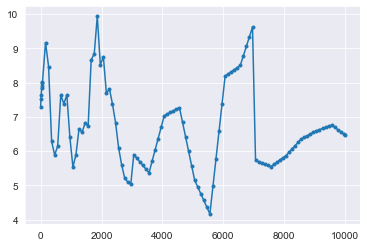

In [12]:
#this is a test cell to compare data with LSD- won't work unless you have the text files.
use = LSD_SPhi_test[0:107]
use_numpy = use.to_numpy()
use_numpy[0]
use2 = LSD_SPhi_test.to_numpy()
use2[0]
LSD_sf_test = pd.read_csv('LSD_sf_test.txt', header=None)
LSD_rc_test = pd.read_csv('LSD_rc_test', header=None)
LSD_rc_test_numpy = LSD_rc_test.to_numpy()
LSD_tv_test = pd.read_csv('LSD_tv_Test', header = None)
plt.plot(LSD_tv_test, LSD_rc_test, markersize = 3, marker = 'o')
#plt.plot(0, Rc[0], marker = '*')


In [13]:
PhiL_list = []
p3n = []
p3n_cpx = []
p3n_ol = []
p3n_qtz = []
# Energy spectrum [MeV]. From Sato & Nita (2006 or 2008, one has neutrons one has protons)
# Energy spectrum doesn't start exactly at 0 because we were having problems with division by 0. 
s = 465; #Solar modulation- need to fix this
w = 0.06
x = sample_pressure*1.019716
Et = 2.5e-8; #Thermal neutron energy in MeV
Rc = LSD_rc_test_numpy #use this line if you want to test 
## Integrated neutron flux <15 MeV

smin = 400; #Units of MV
smax = 1200; #Units of MV

# Ground-Level Spectrum
g3 = 10**(ground_level_spectrum.iloc[0]['values'] + (ground_level_spectrum.iloc[1]['values'])/(w + ground_level_spectrum.iloc[2]['values']))
g5 = ground_level_spectrum.iloc[3]['values'] + (ground_level_spectrum.iloc[4]['values']*w) + ground_level_spectrum.iloc[5]['values']*(w**2);
fG = 10**(ground_level_spectrum.iloc[6]['values'] + ground_level_spectrum.iloc[7]['values']*np.log10(E/g3)*(1-np.tanh(ground_level_spectrum.iloc[8]['values']*np.log10(E/g5))))

# Thermal Neutron Spectrum
g6 = (thermal_neutron_spectrum.iloc[0]['values'] + thermal_neutron_spectrum.iloc[1]['values']*np.exp(-thermal_neutron_spectrum.iloc[2]['values']*w))/(1 + thermal_neutron_spectrum.iloc[3]['values']*np.exp(-thermal_neutron_spectrum.iloc[4]['values']*w))

PhiT = g6*((E/Et)**2)*np.exp(-E/Et)

# Total Ground-Level Flux

PhiB = np.zeros((1,len(E)))
PhiG = np.zeros((1,len(E)))
PhiGMev = np.zeros((1,len(E)))
p3n_temp = np.zeros((1,len(E)))

empty = []
for a in range(len(Rc)):
    a1min = b_values.iloc[0]['values'] + b_values.iloc[2]['values']*Rc[a] + b_values.iloc[4]['values']/(1 + np.exp((Rc[a] - b_values.iloc[6]['values'])/b_values.iloc[8]['values']))
    a1max = b_values.iloc[1]['values'] + b_values.iloc[3]['values']*Rc[a] + b_values.iloc[5]['values']/(1 + np.exp((Rc[a] - b_values.iloc[7]['values'])/b_values.iloc[9]['values']))
    a2min = b_values.iloc[10]['values'] + b_values.iloc[12]['values']*Rc[a] + b_values.iloc[14]['values']/(1 + np.exp((Rc[a] - b_values.iloc[16]['values'])/b_values.iloc[18]['values']))
    a2max = b_values.iloc[11]['values'] + b_values.iloc[13]['values']*Rc[a] + b_values.iloc[15]['values']/(1 + np.exp((Rc[a] - b_values.iloc[17]['values'])/b_values.iloc[19]['values']))
    a3min = b_values.iloc[20]['values'] + b_values.iloc[22]['values']*Rc[a] + b_values.iloc[24]['values']/(1 + np.exp((Rc[a] - b_values.iloc[26]['values'])/b_values.iloc[28]['values']))
    a3max = b_values.iloc[21]['values'] + b_values.iloc[23]['values']*Rc[a] + b_values.iloc[25]['values']/(1 + np.exp((Rc[a] - b_values.iloc[27]['values'])/b_values.iloc[29]['values']))
    a4min = b_values.iloc[30]['values'] + b_values.iloc[32]['values']*Rc[a] + b_values.iloc[34]['values']/(1 + np.exp((Rc[a] - b_values.iloc[36]['values'])/b_values.iloc[38]['values']))
    a4max = b_values.iloc[31]['values'] + b_values.iloc[33]['values']*Rc[a] + b_values.iloc[35]['values']/(1 + np.exp((Rc[a] - b_values.iloc[37]['values'])/b_values.iloc[39]['values']))

    a5 = basic_spectrum.iloc[0]['values'] + basic_spectrum.iloc[1]['values']*Rc[a] + basic_spectrum.iloc[2]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[3]['values'])/basic_spectrum.iloc[4]['values']))
    a9 = basic_spectrum.iloc[5]['values'] + basic_spectrum.iloc[6]['values']*Rc[a] + basic_spectrum.iloc[7]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[8]['values'])/basic_spectrum.iloc[9]['values']));
    a10 = basic_spectrum.iloc[10]['values'] + basic_spectrum.iloc[11]['values']*Rc[a] + basic_spectrum.iloc[12]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[13]['values'])/basic_spectrum.iloc[14]['values']));
    a11 = basic_spectrum.iloc[15]['values'] + basic_spectrum.iloc[16]['values']*Rc[a] + basic_spectrum.iloc[17]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[18]['values'])/basic_spectrum.iloc[19]['values']));

    b5 = b_values.iloc[40]['values'] + b_values.iloc[41]['values']*Rc[a] + b_values.iloc[42]['values']/(1 + np.exp((Rc[a] - b_values.iloc[43]['values'])/b_values.iloc[44]['values']))
    b6 = b_values.iloc[45]['values'] + b_values.iloc[46]['values']*Rc[a] + b_values.iloc[47]['values']/(1 + np.exp((Rc[a] - b_values.iloc[48]['values'])/b_values.iloc[49]['values']))
    c4 = a5 + a_values.iloc[0]['values']*x/(1 + a_values.iloc[1]['values']*np.exp(a_values.iloc[2]['values']*x)) #lethargy^-1
    c12 = a9*(np.exp(-a10*x) + a11*np.exp(-a_values.iloc[3]['values']*x)) # MeV

    PhiLmin = a1min*(np.exp(-a2min*x) - a3min*np.exp(-a4min*x)) #Length of Rc
    PhiLmax = a1max*(np.exp(-a2max*x) - a3max*np.exp(-a4max*x)) #Length of Rc
    empty.append(PhiLmin)
    f3 = b5 + (b6*x)
    f2 = (PhiLmin - PhiLmax)/(smin**f3 - smax**f3)
    f1 = PhiLmin - f2*smin**f3;
    
    PhiL = f1 + (f2*s**f3)
    PhiL_list.append(PhiL)
    
    PhiB = (c_values.iloc[0]['values']*(E/c_values.iloc[1]['values'])**c_values.iloc[2]['values'])*np.exp(-E/c_values.iloc[1]['values']) + c4*np.exp((-(np.log10(E) - np.log10(c_values.iloc[3]['values']))**2)/(2*(np.log10(c_values.iloc[4]['values']))**2)) + c_values.iloc[5]['values']*np.log10(E/c_values.iloc[6]['values'])*(1 + np.tanh(c_values.iloc[7]['values']*np.log10(E/c_values.iloc[8]['values'])))*(1 - np.tanh(c_values.iloc[9]['values']*np.log10(E/c12)))

for i in range(len(Rc)):
    PhiG = PhiL_list[i]*(PhiB*fG + PhiT)
    df2 = PhiG/E
    PhiGMev = pd.DataFrame(df2)
    a = PhiGMev.to_numpy()
    b = E.to_numpy()
    c = Onx3HeT.to_numpy()
    d = Sinx3HeT.to_numpy()
    e = Fenx3HeT.to_numpy()
    f = Canx3HeT.to_numpy()
    g = Mgnx3HeT.to_numpy()
    h = Alnx3HeT.to_numpy()
    PhiGMev_array = np.reshape(a, 200)
    E_array = np.reshape(b, 200)
    Onx3HeT_array = np.reshape(c,200)
    Sinx3HeT_array = np.reshape(d,200)
    Fenx3HeT_array = np.reshape(e,200)
    Canx3HeT_array = np.reshape(f,200)
    Mgnx3HeT_array = np.reshape(g,200)
    Alnx3HeT_array = np.reshape(h,200)

    #Quartz
    if system == 1: #qtz
        p3n_temp_qtz = (np.trapz(PhiGMev_array*Onx3HeT_array,E_array) + np.trapz(PhiGMev_array*(Sinx3HeT_array/2), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3n_qtz.append(p3n_temp_qtz)
    #Inserted from Dave Parmelee's code (MS thesis, NMT 2014) to account for composition
    #dependence of clinopyroxene
    if system == 2: #cpx
        p3n_temp_cpx = (np.trapz(PhiGMev_array*Onx3HeT_array, E_array) +
        np.trapz(PhiGMev_array*(Sinx3HeT_array*1.92/6),E_array) +
        np.trapz(PhiGMev_array*(Alnx3HeT_array*0.12/6),E_array) +
        np.trapz(PhiGMev_array*(Mgnx3HeT_array*0.67/6), E_array) +
        np.trapz(PhiGMev_array*(Fenx3HeT_array*0.31/6), E_array) +
        np.trapz(PhiGMev_array*(Canx3HeT_array*0.86/6), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3n_cpx.append(p3n_temp_cpx)
    if system == 3: #olivine
        p3n_temp_ol = (np.trapz(PhiGMev_array*Onx3HeT_array, E_array) +
        np.trapz(PhiGMev_array*(Sinx3HeT_array*1/4), E_array) + 
        np.trapz(PhiGMev_array*(Mgnx3HeT_array*1.1/4), E_array) +
        np.trapz(PhiGMev_array*(Fenx3HeT_array*0.9/4), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3n_ol.append(p3n_temp_ol)
p3n_qtz

[165.27791580701307,
 162.36333043676737,
 160.95325433782725,
 158.80417877745919,
 158.0434453089261,
 156.92348025967917,
 156.66583226361925,
 145.73086260531187,
 152.03765087349623,
 179.16946844544336,
 184.97312114720708,
 181.0924442068582,
 161.15270256073012,
 164.22295263484258,
 161.15270256073012,
 177.50012619182897,
 190.09543383942085,
 184.72962833064088,
 173.97565678982164,
 175.37588660552638,
 171.67440159825688,
 172.81968143922114,
 150.11494574033466,
 148.588667677967,
 139.94885145126963,
 151.5474744549632,
 149.34334150847081,
 160.5563743714793,
 158.9961082549398,
 164.432722157937,
 171.4466932579456,
 181.8170464451043,
 189.11988754579195,
 194.70808185963924,
 196.39253779900255,
 197.35005624436113,
 184.72962833064088,
 186.2892938012788,
 187.85091693382668,
 189.41263008374344,
 190.97258102489957,
 192.528943864213,
 187.65567092213465,
 182.78565147801578,
 177.9756709187816,
 173.2808295669616,
 168.7518366565961,
 168.13361584194732,
 167.5196

In [14]:
#PROTONS
p3p_cpx = []
p3p_ol = []
p3p_qtz = []
A = 1
Z = 1
Ep = 938.27 #Rest mass of a proton
U = (4-1.675)*(np.pi)*(A/Z)*1e-7 # Unit conversion factor
p3p = []
s = 465
x = sample_pressure*1.01976
#Primary spectrum
Etoa = E + primary_spectrum.iloc[0]['values']*x
Rtoa = 0.001*np.sqrt((A*Etoa)**2 + 2*A*Ep*Etoa)/Z
Rc = LSD_rc_test_numpy
Elis = np.zeros((1,len(E)))
Beta = np.zeros((1,len(E)))
Rlis =np.zeros((1,len(E)))
phiTOA = np.zeros((1,len(E)))
phiLIS = np.zeros((1,len(E)))
phiSec = np.zeros((1,len(E)))
phiPtot = np.zeros((1,len(E)))
p10p = np.zeros((1,len(E)))

b1 = secondary_spectrum.iloc[0]['values'] + secondary_spectrum.iloc[1]['values']*x + secondary_spectrum.iloc[2]['values']*x**2 + secondary_spectrum.iloc[3]['values']*x**3
b2 = secondary_spectrum.iloc[4]['values'] + secondary_spectrum.iloc[5]['values']*x + secondary_spectrum.iloc[6]['values']*x**2 + secondary_spectrum.iloc[7]['values']*x**3
b3 = secondary_spectrum.iloc[8]['values'] + secondary_spectrum.iloc[9]['values']*x + secondary_spectrum.iloc[10]['values']*x**2 + secondary_spectrum.iloc[11]['values']*x**3
b4 = secondary_spectrum.iloc[12]['values'] + secondary_spectrum.iloc[13]['values']*x + secondary_spectrum.iloc[14]['values']*x**2 + secondary_spectrum.iloc[15]['values']*x**3


#Combine primary and secondary spectra

for a in range(len(Rc)):
    cp = Opx3HeT.to_numpy()
    dp = Sipx3HeT.to_numpy()
    Opx3HeT_array = np.reshape(cp,200)
    Sipx3HeT_array = np.reshape(dp,200)
   
    Elis = Etoa + s*Z/A
    Beta = np.sqrt(1-(Ep/(Ep + Elis*A))**2) # Particle speed relative to light
    Rlis = 0.001*np.sqrt((A*Elis)**2 + 2*A*Ep*Elis)/Z
    C = primary_spectrum.iloc[6]['values'] + primary_spectrum.iloc[7]['values']/(1 + np.exp((Elis - primary_spectrum.iloc[8]['values'])/primary_spectrum.iloc[9]['values']))
    phiTOA = (C*(Beta**primary_spectrum.iloc[4]['values'])/(Rlis**primary_spectrum.iloc[5]['values']))*(Rtoa/Rlis)**2
    phiPri = (U/Beta)*phiTOA*(primary_spectrum.iloc[1]['values']*np.exp(-primary_spectrum.iloc[2]['values']*x) + (1 - primary_spectrum.iloc[1]['values'])*np.exp(-primary_spectrum.iloc[3]['values']*x))
    
    g1min = h_values_protons.iloc[0]['values'] + h_values_protons.iloc[2]['values']*Rc[a] + h_values_protons.iloc[4]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[6]['values'])/h_values_protons.iloc[8]['values']))
    g1max = h_values_protons.iloc[1]['values'] + h_values_protons.iloc[3]['values']*Rc[a] + h_values_protons.iloc[5]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[7]['values'])/h_values_protons.iloc[9]['values']))
    g2min = h_values_protons.iloc[10]['values'] + h_values_protons.iloc[12]['values']*Rc[a] + h_values_protons.iloc[14]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[16]['values'])/h_values_protons.iloc[18]['values']))
    g2max = h_values_protons.iloc[11]['values'] + h_values_protons.iloc[13]['values']*Rc[a] + h_values_protons.iloc[15]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[17]['values'])/h_values_protons.iloc[19]['values']))
    g3min = h_values_protons.iloc[20]['values'] + h_values_protons.iloc[22]['values']*Rc[a] + h_values_protons.iloc[24]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[26]['values'])/h_values_protons.iloc[28]['values']))
    g3max = h_values_protons.iloc[21]['values'] + h_values_protons.iloc[23]['values']*Rc[a] + h_values_protons.iloc[25]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[27]['values'])/h_values_protons.iloc[29]['values']))
    g4min = h_values_protons.iloc[30]['values'] + h_values_protons.iloc[32]['values']*Rc[a] + h_values_protons.iloc[34]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[36]['values'])/h_values_protons.iloc[38]['values']))
    g4max = h_values_protons.iloc[31]['values'] + h_values_protons.iloc[33]['values']*Rc[a] + h_values_protons.iloc[35]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[37]['values'])/h_values_protons.iloc[39]['values']))

    phiPmin = g1min*(np.exp(-g2min*x) - g3min*np.exp(-g4min*x)) #length of Rc
    phiPmax = g1max*(np.exp(-g2max*x) - g3max*np.exp(-g4max*x)) #length of Rc

    g5 = h_values_protons.iloc[40]['values'] + h_values_protons.iloc[41]['values']*Rc[a] + h_values_protons.iloc[42]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[43]['values'])/h_values_protons.iloc[44]['values']))
    g6 = h_values_protons.iloc[45]['values'] + h_values_protons.iloc[46]['values']*Rc[a] + h_values_protons.iloc[47]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[48]['values'])/h_values_protons.iloc[49]['values']))

    f3 = g5 + g6*x
    f2 = (phiPmin - phiPmax)/(smin**f3 - smax**f3)
    f1 = phiPmin - f2*smin**f3

    phiP = f1 + f2*s**f3
    
    phiSec = (phiP*b1*E**b2)/(1 + b3*E**b4)
    
    Ec = (np.sqrt((1000*Rc[a]*Z)**2 + Ep**2) - Ep)/A
    Es = primary_spectrum.iloc[12]['values']*(Ec - primary_spectrum.iloc[13]['values']*x)
    Es1 = max(primary_spectrum.iloc[14]['values'],Es)
    Es2 = max(primary_spectrum.iloc[15]['values'],Es)   
   
    df2p = phiPri*(np.tanh(primary_spectrum.iloc[10]['values']*(E/Es1 - 1)) + 1)/2 + phiSec*(np.tanh(primary_spectrum.iloc[11]['values']*(1 - E/Es2)) + 1)/2
    phiPtot = pd.DataFrame(df2p)
    ap = phiPtot.to_numpy()    
    phiPtot_array = np.reshape(ap, 200)
    
    cp = Onx3HeT.to_numpy()
    dp = Sinx3HeT.to_numpy()
    ep = Fenx3HeT.to_numpy()
    fp = Canx3HeT.to_numpy()
    gp = Mgnx3HeT.to_numpy()
    hp = Alnx3HeT.to_numpy()
    Opx3HeT_array = np.reshape(cp,200)
    Sipx3HeT_array = np.reshape(dp,200)
    Fepx3HeT_array = np.reshape(ep,200)
    Capx3HeT_array = np.reshape(fp,200)
    Mgpx3HeT_array = np.reshape(gp,200)
    Alpx3HeT_array = np.reshape(hp,200)
    
    if system == 1:
        p3p_temp_qtz = (np.trapz(phiPtot_array*Opx3HeT_array,E_array) + np.trapz(phiPtot_array*(Sipx3HeT_array/2),E_array))*2.00600000000000e22*1e-27*3.1536e7   
        p3p_qtz.append(p3p_temp_qtz)
    if system == 2:
        p3p_temp_cpx = (np.trapz(phiPtot_array*Opx3HeT_array, E_array) +
        np.trapz(phiPtot_array*(Sipx3HeT_array*1.92/6),E_array) +
        np.trapz(phiPtot_array*(Alpx3HeT_array*0.12/6),E_array) +
        np.trapz(phiPtot_array*(Mgpx3HeT_array*0.67/6), E_array) +
        np.trapz(phiPtot_array*(Fepx3HeT_array*0.31/6), E_array) +
        np.trapz(phiPtot_array*(Capx3HeT_array*0.86/6), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3p_cpx.append(p3p_temp_cpx)
    if system == 3: 
        p3p_temp_ol = (np.trapz(phiPtot_array*Opx3HeT_array, E_array) +
        np.trapz(phiPtot_array*(Sipx3HeT_array*1/4), E_array) + 
        np.trapz(phiPtot_array*(Mgpx3HeT_array*1.1/4), E_array) +
        np.trapz(phiPtot_array*(Fepx3HeT_array*0.9/4), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3p_ol.append(p3p_temp_ol)
p3p_qtz


[32.42457979054503,
 31.791773614307683,
 31.493056272710678,
 31.054680407238923,
 30.905672809864367,
 30.693143040093886,
 30.64547661320379,
 29.073703518031138,
 29.875625957416943,
 35.03671328691194,
 35.606682947917825,
 35.26905718722309,
 31.534856388103428,
 32.19418547168225,
 31.534856388103428,
 34.8021940078849,
 35.77310542607014,
 35.590810072454964,
 34.21686418251538,
 34.463016324053726,
 33.77899361325533,
 34.001663014884386,
 29.60493421909334,
 29.408521427392433,
 28.40808139193772,
 29.803968072680355,
 29.503764094572357,
 31.410385119391055,
 31.09282780880002,
 32.23993738141238,
 33.733707361725074,
 35.34565001093815,
 35.76606811914382,
 35.650377761407455,
 35.54143005576858,
 35.46402886710533,
 35.590810072454964,
 35.67999735092045,
 35.73957375165715,
 35.76939515643204,
 35.76956799966502,
 35.74037587393144,
 35.733753663852866,
 35.438419233560865,
 34.87199251986309,
 34.08873009985668,
 33.17694110418822,
 33.04493698776226,
 32.91274165739082,

#this is a test cell to compare to LSD, won't work unless you have the text files.
phiTOAx = pd.read_csv('phiTOA_test', header = None)
phiTOAy = phiTOAx.to_numpy()
phiTOA = np.reshape(phiTOAx,200)
np.shape(phiTOA)
phiPtot_balco = pd.read_csv('phiPtot_balco', header = None)
base = phiPtot_balco*1e-6
basex = pd.DataFrame(base)
jp = basex.to_numpy()    
base_array = np.reshape(jp, 200)
#plt.plot(base_array, 'o', phiPtot, '-')
plt.plot(phiPtot_array-base_array)

## Scaling Factor
- Calculated based on LSD code
- Based on whatever system (i.e., qtz/cpx/olivine) that the user specifies, it will generate a list of scaling factors. The other cells will not produce a scaling factor if that system was not chosen (i.e., if you specify quartz, the cpx and olivine lists will be empty). 

In [65]:
#qtz
SiteHe_qtz = []
#Nuclide Specific Scaling Factors
p3nref = 90.1971
p3pref = 13.6357
HeRef_qtz = p3nref + p3pref #reference production rate
#Nuclide specific scaling factors as f(Rc)

for i in range(len(p3n_qtz)):
    SiteHe_temp_qtz = (p3n_qtz[i]+ p3p_qtz[i])/HeRef_qtz #scaling factor
    SiteHe_qtz.append(SiteHe_temp_qtz)
SiteHe_qtz

[1.9040466557538476,
 1.8698821957134455,
 1.853425031498119,
 1.8285056281319398,
 1.8197440319320144,
 1.8069109501022127,
 1.8039705071694399,
 1.68351971750105,
 1.7519827726008848,
 2.062991479882612,
 2.124374996100701,
 2.0837490792320086,
 1.8557484624206757,
 1.8916675473118787,
 1.8557484624206757,
 2.044655640604066,
 2.175310106878472,
 2.1218770793342356,
 2.0050747063773398,
 2.020930793829889,
 1.9786945474985957,
 1.9918690862049904,
 1.7308584566671417,
 1.7142674482953308,
 1.6214234119007418,
 1.7465718205388236,
 1.722452881970275,
 1.8488065379231837,
 1.8307214682040724,
 1.8941284405250496,
 1.9760653725958528,
 2.091465283186454,
 2.165846973836165,
 2.2185519375481224,
 2.233725449518564,
 2.2422017427197036,
 2.1218770793342356,
 2.1377569626572646,
 2.1533705215065355,
 2.168698380860147,
 2.1837237272284344,
 2.1984317069186656,
 2.1514340804253327,
 2.101687238633424,
 2.0499077694008507,
 1.997148874602421,
 1.9447494217702337,
 1.9375241044227796,
 1.9303

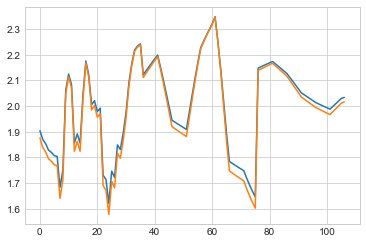

In [36]:
plt.plot(SiteHe_qtz)
plt.plot(LSD_sf_test)

In [37]:
#SiteHe for cpx:
SiteHe_cpx = []
#Nuclide Specific Scaling Factors
p3nref = 90.1971
p3pref = 13.6357
HeRef = p3nref + p3pref #reference production rate
#Nuclide specific scaling factors as f(Rc)

for i in range(len(p3n_cpx)):
    SiteHe_temp_cpx = (p3n_cpx[i] + p3p_cpx[i])/HeRef #scaling factor
    SiteHe_cpx.append(SiteHe_temp_cpx)
SiteHe_cpx

[]

In [38]:
#olivine
SiteHe_ol = []
#Nuclide Specific Scaling Factors
p3nref = 90.1971
p3pref = 13.6357
HeRef_ol = p3nref + p3pref #reference production rate
#Nuclide specific scaling factors as f(Rc)

for i in range(len(p3n_ol)):
    SiteHe_temp_ol = (p3n_ol[i] + p3p_ol[i])/HeRef #scaling factor
    SiteHe_ol.append(SiteHe_temp_ol)
SiteHe_ol

[]

# Testing/Plotting stuff
- these cells are not for calculation purposes
- used for making plots/comparisons

## Evenstar Dataset Comparisons

In [39]:
# TEST EVENSTAR DATA
#Calculate Rc:
theta = -20.101167
Rc = 14.9*(np.cos(np.deg2rad(theta)))**4

In [40]:
#Calculate Scaling Factor (Stone, 2000): used https://hess.ess.washington.edu/math/docs/al_be_v2/al_be_fctn_desc/node26.html
a = 40.3153
b = 308.9894
c = -0.106248
d = 9.4508e-5
e = -2.8234e-8
elevation = 1380 #m above sea level
h = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (elevation*dtdz)))) #this is from nat's code, convert elevation to atm pressure
sf_stone = a + b*(np.exp(-h/150)) + c*h + d*(h**2) + e*(h**3)
sf_stone

1.9055098580838425

In [41]:
# TEST EVENSTAR DATA 2
#Calculate Rc:
theta_2 = -19.578942
Rc_2 = 14.9*(np.cos(np.deg2rad(theta_2)))**4
Rc_2

11.741485417739906

In [42]:
#Calculate Scaling Factor 2 (Stone, 2000): used https://hess.ess.washington.edu/math/docs/al_be_v2/al_be_fctn_desc/node26.html
a_2 = 40.3153
b_2 = 308.9894
c_2 = -0.106248
d_2 = 9.4508e-5
e_2 = -2.8234e-8
elevation_2 = 1172 #m above sea level
h_2 = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (elevation_2*dtdz)))) #this is from nat's code, convert elevation to atm pressure
sf_stone_2 = a + b*(np.exp(-h_2/150)) + c*h_2 + d*(h_2**2) + e*(h_2**3)
sf_stone_2

1.6360429265153016

In [754]:
# TEST EVENSTAR DATA 3
#Calculate Rc:
theta_3 = -19.987111
Rc_3 = 14.9*(np.cos(np.deg2rad(theta_3)))**4
Rc_3

11.621755099857952

In [755]:
#Calculate Scaling Factor 3 (Stone, 2000): used https://hess.ess.washington.edu/math/docs/al_be_v2/al_be_fctn_desc/node26.html
a_3 = 40.3153
b_3 = 308.9894
c_3 = -0.106248
d_3 = 9.4508e-5
e_3 = -2.8234e-8
elevation_3 = 1943 #m above sea level
h_3 = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (elevation_3*dtdz)))) #this is from nat's code, convert elevation to atm pressure
sf_stone_3 = a + b*(np.exp(-h_3/150)) + c*h_3 + d*(h_3**2) + e*(h_3**3)
sf_stone_3

2.82288833606283

In [756]:
# TEST EVENSTAR DATA 4
#Calculate Rc:
theta_4 = -18.886583
Rc_4 = 14.9*(np.cos(np.deg2rad(theta_4)))**4
Rc_4

11.941167193385313

In [757]:
#Calculate Scaling Factor 4 (Stone, 2000): used https://hess.ess.washington.edu/math/docs/al_be_v2/al_be_fctn_desc/node26.html
a_4 = 40.3153
b_4 = 308.9894
c_4 = -0.106248
d_4 = 9.4508e-5
e_4 = -2.8234e-8
elevation_4 = 2282 #m above sea level
h_4 = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (elevation_4*dtdz)))) #this is from nat's code, convert elevation to atm pressure
sf_stone_4 = a + b*(np.exp(-h_4/150)) + c*h_4 + d*(h_4**2) + e*(h_4**3)
sf_stone_4

3.5220675872637646

In [758]:
# TEST EVENSTAR DATA 5
#Calculate Rc:
theta_5 = -19.786306
Rc_5 = 14.9*(np.cos(np.deg2rad(theta_5)))**4
Rc_5

11.68083957417214

In [759]:
#Calculate Scaling Factor 5 (Stone, 2000): used https://hess.ess.washington.edu/math/docs/al_be_v2/al_be_fctn_desc/node26.html
a_5 = 40.3153
b_5 = 308.9894
c_5 = -0.106248
d_5 = 9.4508e-5
e_5 = -2.8234e-8
elevation_5 = 1289 #m above sea level
h_5 = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (elevation_5*dtdz)))) #this is from nat's code, convert elevation to atm pressure
sf_stone_5 = a + b*(np.exp(-h_5/150)) + c*h_5 + d*(h_5**2) + e*(h_5**3)
sf_stone_5

1.7833058318762873

In [760]:
# TEST EVENSTAR DATA 6
#Calculate Rc:
theta_6 = -19.397833
Rc_6 = 14.9*(np.cos(np.deg2rad(theta_6)))**4

In [761]:
#Calculate Scaling Factor 6 (Stone, 2000): used https://hess.ess.washington.edu/math/docs/al_be_v2/al_be_fctn_desc/node26.html
a_6 = 40.3153
b_6 = 308.9894
c_6 = -0.106248
d_6 = 9.4508e-5
e_6 = -2.8234e-8
elevation_6 = 1256 #m above sea level
h_6 = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (elevation_6*dtdz)))) #this is from nat's code, convert elevation to atm pressure
sf_stone_6 = a + b*(np.exp(-h_6/150)) + c*h_6 + d*(h_6**2) + e*(h_6**3)
sf_stone_6

1.7406624227432346

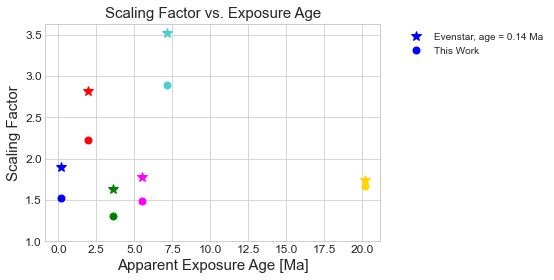

In [762]:
yticks = [1, 1.5, 2, 2.5,3,3.5]
plt.plot(.14, sf_stone, '*', color = 'blue', markersize = 10, label = 'Evenstar, age = 0.14 Ma')
plt.plot(.14,1.521104118745056, 'o',color = 'blue', markersize = 7, label = 'This Work')

plt.plot(3.58, sf_stone_2, '*',color = 'green', markersize = 10)
plt.plot(1.95, sf_stone_3, '*', color = 'red',markersize = 10)
plt.plot(7.15, sf_stone_4, '*',color = 'mediumturquoise',  markersize = 10)
plt.plot(5.52, sf_stone_5, '*',color = 'magenta',  markersize = 10)
plt.plot(20.17, sf_stone_6, '*', color = 'gold',markersize = 10)

plt.plot(3.58,1.3059648060179956, 'o',color = 'green', markersize = 7)
plt.plot(1.95,2.227475485294011, 'o', color = 'red',markersize = 7)
plt.plot(7.15, 2.8901958423299106, 'o',color = 'mediumturquoise', markersize = 7)
plt.plot(5.52, 1.490646128629074, 'o', color = 'magenta',markersize = 7)
plt.plot(20.17, 1.6701768455362207, 'o',color = 'gold', markersize = 7)

plt.yticks(ticks = yticks, fontsize = 12)
plt.xticks(fontsize = 12)
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Apparent Exposure Age [Ma]',fontsize=15)
plt.ylabel('Scaling Factor',fontsize=15)
plt.title('Scaling Factor vs. Exposure Age',fontsize=15)
plt.savefig('Scaling_factor_vs_exposure_age.png', dpi = 300, bbox_inches='tight')

# Bins = 1 Ma

In [15]:
timeb = np.arange(1,71) #will report paleolatitude values from 0-70 Million years ago, in 1 Myr increments 
#NOTE: starting at 1 because pmagpy only works with whole numbers (i.e., can't start from 0.05 Ma)
valsb = [] #storage for pmagpy data 
for i in timeb:
    datab =['NA',site_lat,site_lon,i] # North American plate
    pmag.apwp(datab, print_results = False) #change to true if you want to see the output
    valsb.append(pmag.apwp(datab))
dfb = pd.DataFrame(valsb) #create a dataframe with the pmagpy data
dfb.columns = ['Age', 'Paleolat', 'Dec','Inc','Pole_lat','Pole_Long'] #rename the columns
Paleolatb = dfb['Paleolat'] #call paleolat whenever you want all the paleolatitudes for some time frame

In [16]:
#This cell assigns bins automatically in 1 Myr chunks.
meansb = []
for i in range(0, 70):
    globals()[f"binb_{i}"] = Paleomag_database[(Paleomag_database['AGE'] <= i+1) & (Paleomag_database['AGE'] > i)]
    globals()[f"binb_{i}"] = globals()[f"binb_{i}"][pd.to_numeric(globals()[f"binb_{i}"]['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
    globals()[f"binb_{i}"]['VDM'] = globals()[f"binb_{i}"]['VDM'].astype(float)
    meansb.append((globals()[f"binb_{i}"]["VDM"].mean()))#calculates mean
    globals()[f"indexb_{i}"] = globals()[f"binb_{i}"].index
    globals()[f"nb_{i}"] = len(globals()[f"indexb_{i}"])

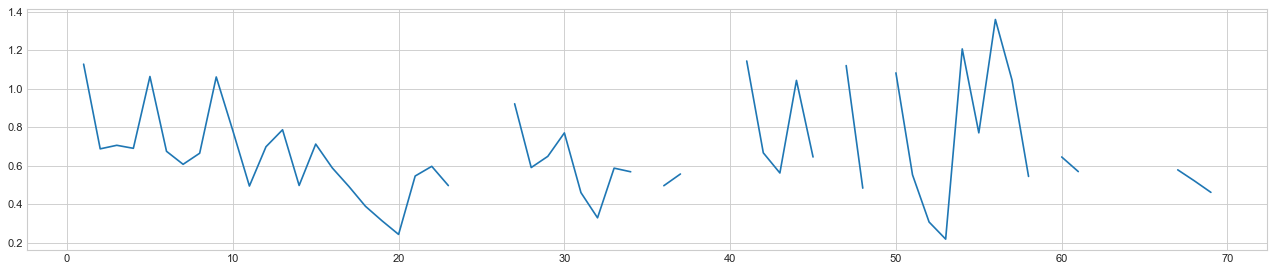

In [17]:
M0 = 7.95 #[*10^22 Am^2], per Katie. constant, magnetic moment today for reference field.
Rcb = []
tempb = []
for i in range(len(Paleolatb)): 
    Rc_calcb = (meansb[i]/M0)*(6.89901*np.cos(np.deg2rad(Paleolatb[i])) - 103.241*(np.cos(np.deg2rad(Paleolatb[i])))**2 + 522.061*(np.cos(np.deg2rad(Paleolatb[i])))**3 - 1152.15*(np.cos(np.deg2rad(Paleolatb[i])))**4 + 1189.18*(np.cos(np.deg2rad(Paleolatb[i])))**5 - 448.004*(np.cos(np.deg2rad(Paleolatb[i])))**6)  #from Lifton (2014)
    Rcb.append(Rc_calcb)
    tempb.append(meansb[i]/M0)
from matplotlib.pyplot import figure
plt.style.use('seaborn-whitegrid')
temp_Rc = pd.read_csv('temp_Rc', header = None)
temp_tv = pd.read_csv('temp_tv', header = None)
figure(figsize=(20, 4), dpi=80)
plt.plot(timeb,tempb)

# Bins = 500,000 years

In [18]:
timec = np.linspace(1,70,140) #will report paleolatitude values from 0-70 Million years ago, in 500,000 yr increments 
valsc = [] #storage for pmagpy data 
for i in timec:
    datac =['NA',site_lat,site_lon,i] # North American plate, lat and lon of San Diego at 100 Ma (user inputs lat and long of site of interest)
    pmag.apwp(datac, print_results = False) #change to true if you want to see the output
    valsc.append(pmag.apwp(datac))
dfc = pd.DataFrame(valsc) #create a dataframe with the pmagpy data
dfc.columns = ['Age', 'Paleolat', 'Dec','Inc','Pole_lat','Pole_Long'] #rename the columns
Paleolatc = dfc['Paleolat'] #call paleolat whenever you want all the paleolatitudes for some time frame


In [19]:
meansc = []
for i in timec:
    globals()[f"binc_{i}"] = Paleomag_database[(Paleomag_database['AGE'] <= i+1) & (Paleomag_database['AGE'] > i)]
    globals()[f"binc_{i}"] = globals()[f"binc_{i}"][pd.to_numeric(globals()[f"binc_{i}"]['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
    globals()[f"binc_{i}"]['VDM'] = globals()[f"binc_{i}"]['VDM'].astype(float)
    meansc.append((globals()[f"binc_{i}"]["VDM"].mean()))#calculates mean
    globals()[f"indexc_{i}"] = globals()[f"binc_{i}"].index
    globals()[f"nc_{i}"] = len(globals()[f"indexc_{i}"])

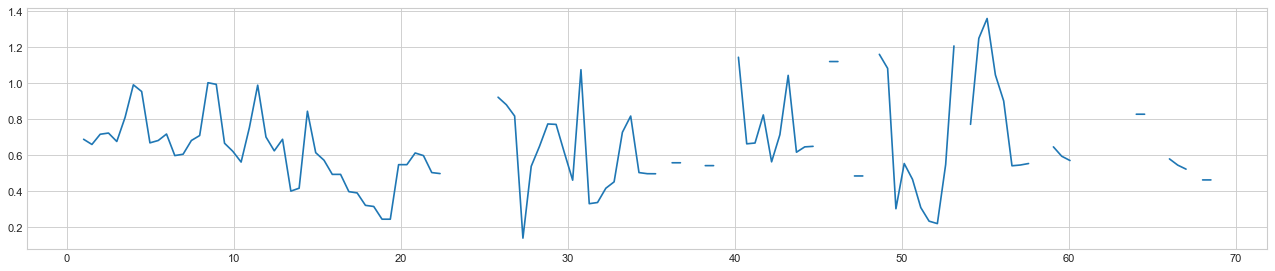

In [20]:
M0 = 7.95 #[*10^22 Am^2], per Katie. constant, magnetic moment today for reference field.
Rcc = []
tempc = []
for i in range(len(Paleolatc)): 
    Rc_calcc = (meansc[i]/M0)*(6.89901*np.cos(np.deg2rad(Paleolatc[i])) - 103.241*(np.cos(np.deg2rad(Paleolatc[i])))**2 + 522.061*(np.cos(np.deg2rad(Paleolatc[i])))**3 - 1152.15*(np.cos(np.deg2rad(Paleolatc[i])))**4 + 1189.18*(np.cos(np.deg2rad(Paleolatc[i])))**5 - 448.004*(np.cos(np.deg2rad(Paleolatc[i])))**6)  #from Lifton (2014)
    Rcc.append(Rc_calcc)
    tempc.append(meansc[i]/M0)
from matplotlib.pyplot import figure
seaborn.set_style('whitegrid', {'legend.frameon':True})
plt.style.use('seaborn-whitegrid')
figure(figsize=(20, 4), dpi=80)
plt.plot(timec,tempc)

[0.025, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0, 27.5, 30.0, 32.5, 35.0]


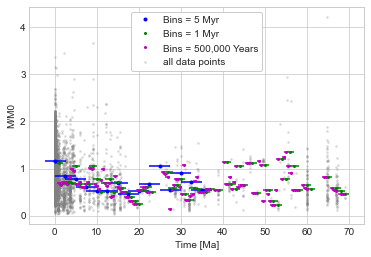

In [40]:
#Plot relative intensity from varying bins, along with *all* relative intensities
time_adjusted = []
for i in range(len(time)):
    time_adjusted_temp = time[i]/2
    time_adjusted.append(time_adjusted_temp)

plt.plot(time_adjusted,temp,'o', markersize = 3, color = 'b', label = 'Bins = 5 Myr')
plt.errorbar(time_adjusted,temp, xerr = 2.5, yerr = None, ecolor = 'b' ,ls = 'none')
plt.plot(timeb,tempb, 'o', markersize = 2, color = 'g', label = 'Bins = 1 Myr')
plt.errorbar(timeb,tempb, xerr = 1, yerr = None, ecolor = 'g',  ls = 'none')
plt.plot(timec,tempc, 'o', markersize = 2, color = 'm', label = 'Bins = 500,000 Years')
plt.errorbar(timec,tempc, xerr = 0.5, yerr = None, ecolor = 'm', ls = 'none')
updated = Paleomag_database[pd.to_numeric(Paleomag_database['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
plt.scatter(updated['AGE'], updated['VDM']/M0, label = 'all data points', s = 3, c = 'gray', alpha = 0.2, marker = 'o')

plt.legend(frameon = True,facecolor='white',framealpha=1)
plt.xlabel('Time [Ma]')
plt.ylabel('M/M0')
plt.savefig('Relative intensity_vs_time.png', dpi = 300, bbox_inches='tight')

print(time_adjusted)


,0
0,1.163822
1,0.832384
2,0.780091
3,0.608029
4,0.519526
5,0.532741
6,0.695755
7,0.462857
8,0.518783
9,0.673970


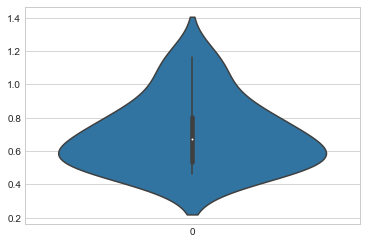

In [29]:
import seaborn as sns
df = pd.DataFrame(temp) #create a dataframe with the pmagpy data
ax = sns.violinplot(data=df)
df

# Constant Paleolatitude Test

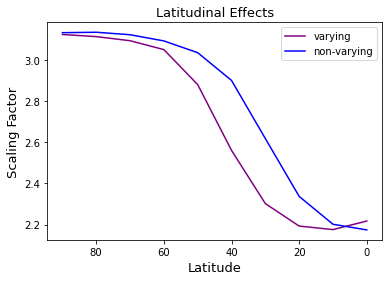

In [30]:
#This cell is to test constant paleolat variations on Rc 
M0 = 7.95 #[*10^22 Am^2], per Katie. constant, magnetic moment today for reference field.
Rc = []
temp = []
Paleolat = 90
for i in range(len(means)): 
    Rc_calc = (means[i]/M0)*(6.89901*np.cos(np.deg2rad(Paleolat)) - 103.241*(np.cos(np.deg2rad(Paleolat)))**2 + 522.061*(np.cos(np.deg2rad(Paleolat)))**3 - 1152.15*(np.cos(np.deg2rad(Paleolat)))**4 + 1189.18*(np.cos(np.deg2rad(Paleolat)))**5 - 448.004*(np.cos(np.deg2rad(Paleolat)))**6)  #from Lifton (2014)
    Rc.append(Rc_calc)
    temp.append(means[i]/M0)
#saved lat figure
#30-35 Ma
x_axis = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
y_axis = [2.2169152234050298, 2.175243065369309, 2.1924046624818176, 2.3020289505718, 2.5616412628133425, 2.882208582513621, 3.0528327981031516, 3.096140558425357, 3.1161575470033327, 3.1264640480889696]
y_axis_2 = [2.173660132234117, 2.201261685431377, 2.337172698384805, 2.6192311487610227, 2.902554895286177, 3.037835435276286, 3.095100975673955, 3.1253512050984433, 3.1374386781386483, 3.1352989562071145]
plt.plot(x_axis, np.flip(y_axis), color = 'purple', label = 'varying')
plt.plot(x_axis,np.flip(y_axis_2), color = 'blue', label = 'non-varying')
ax = plt.gca()
ax.invert_xaxis()
x_axis
plt.title('Latitudinal Effects', fontsize = 13)
plt.xlabel('Latitude', fontsize =13)
plt.ylabel('Scaling Factor', fontsize = 13)
plt.legend()
plt.savefig('latitudinal_effects.png', dpi = 300, bbox_inches='tight')

# Comparisons w/ LSD

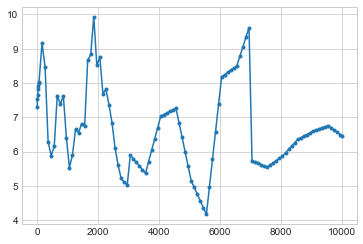

In [26]:
LSD_sf_test = pd.read_csv('LSD_sf_test.txt', header=None)
LSD_rc_test = pd.read_csv('LSD_rc_test', header=None)
LSD_rc_test_numpy = LSD_rc_test.to_numpy()
LSD_tv_test = pd.read_csv('LSD_tv_Test', header = None)
plt.plot(LSD_tv_test, LSD_rc_test, markersize = 3, marker = 'o')
#plt.plot(0, Rc[0], marker = '*')


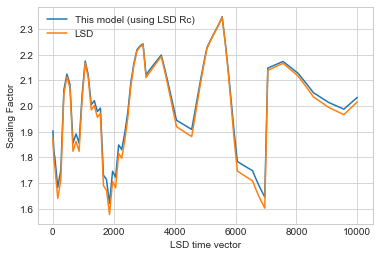

In [25]:
plt.plot(LSD_tv_test, SiteHe_qtz, label = 'This model (using LSD Rc)')
plt.plot(LSD_tv_test, LSD_sf_test, label = 'LSD')
plt.xlabel('LSD time vector')
plt.ylabel('Scaling Factor')
plt.legend()


In [135]:
empty = []
LSD_sf_test_numpy = LSD_sf_test.to_numpy()
for i in range(len(SiteHe_qtz)):
    empty.append(LSD_sf_test_numpy[i] - SiteHe_qtz[i])
empty

[array([1.00040092]),
 array([0.97754148]),
 array([0.9665449]),
 array([0.94991749]),
 array([0.94407968]),
 array([0.93553881]),
 array([0.93358369]),
 array([0.85483336]),
 array([0.8991825]),
 array([1.10720525]),
 array([1.14857992]),
 array([1.1211978]),
 array([0.96809673]),
 array([0.99211366]),
 array([0.96809673]),
 array([1.09485003]),
 array([1.18281741]),
 array([1.14689721]),
 array([1.06820532]),
 array([1.07887426]),
 array([1.05047123]),
 array([1.05932526]),
 array([0.88533924]),
 array([0.87455169]),
 array([0.81668555]),
 array([0.89562679]),
 array([0.87986315]),
 array([0.9634609]),
 array([0.95139466]),
 array([0.99376073]),
 array([1.0487049]),
 array([1.12639981]),
 array([1.17647148]),
 array([1.21166241]),
 array([1.22170201]),
 array([1.22728615]),
 array([1.14689721]),
 array([1.1575906]),
 array([1.16809229]),
 array([1.17838457]),
 array([1.18845127]),
 array([1.19827751]),
 array([1.16679068]),
 array([1.13329081]),
 array([1.09838843]),
 array([1.062875

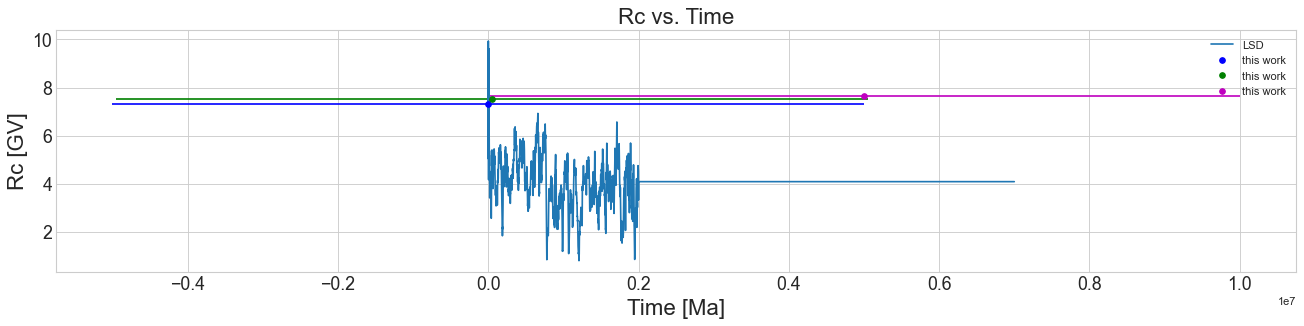

In [151]:
from matplotlib.pyplot import figure

plt.style.use('seaborn-whitegrid')
temp_Rc = pd.read_csv('temp_Rc', header = None)
temp_tv = pd.read_csv('temp_tv', header = None)
figure(figsize=(20, 4), dpi=80)

plt.plot(temp_tv,temp_Rc, label = 'LSD') #calculated using LSD matlab code, converted into text files.
plt.plot(0, Rc[0], 'o', color = 'b',markersize=5, label = 'this work')
plt.errorbar(0, Rc[0],xerr = 5e6, ecolor = 'b', ls = 'none')
plt.plot(0.05e6, Rc[1], 'o',color = 'g', markersize=5, label = 'this work')
plt.errorbar(0.05e6, Rc[1],xerr = 5e6, ecolor = 'g', ls = 'none')
plt.plot(5e6, Rc[2], 'o',color = 'm', markersize=5, label = 'this work')
plt.errorbar(5e6, Rc[2],xerr = 5e6, ecolor = 'm', ls = 'none')

plt.xlabel('Time [Ma]',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Rc [GV]', fontsize=20)
plt.yticks(fontsize = 16)
plt.title('Rc vs. Time', fontsize=20)
plt.legend()
plt.savefig('Rc_vs_time.png', dpi = 300, bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (15,) and (2,)

<Figure size 432x288 with 0 Axes>

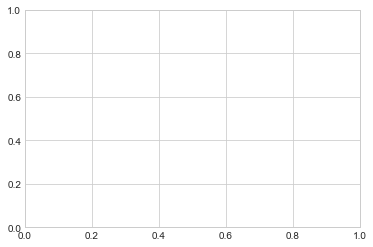

In [34]:
time = [0, 0.05e6,5e6,10e6,15e6,20e6,25e6, 30e6, 35e6, 40e6,45e6,50e6,55e6,60e6,65e6]
fig = plt.figure()
fig, ax = plt.subplots()
plt.plot(time,SiteHe_qtz, '*-', label = '3He in qtz')
plt.plot(time,SiteHe_cpx, '*-', label = '3He in cpx')
plt.plot(time,SiteHe_ol, '*-', label = '3He in olivine')
plt.plot(LSD_sf_tv, LSD_sf, color = 'blue', label = 'LSD')
plt.xlabel('Time [Ma]')
plt.ylabel('Scaling Factor')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Scaling Factor vs. Time')


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


axins = inset_axes(ax, 10,0.5 , loc=2,bbox_to_anchor=(1, 0.25),bbox_transform=ax.figure.transFigure) # no zoom
axins.plot(LSD_sf_tv, LSD_sf, color = 'blue')

x1, x2= 0, 2e6
y1,y2 = 0.50, 0.55
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black")
#for axi in [axins]:
#    axi.tick_params(labelleft=False, labelbottom=False)
plt.savefig('Scaling_factor_vs_time.png', dpi = 300, bbox_inches='tight')


# Solar Modulation 
- if ever needed, doesn't totally work tho

In [ ]:
#Janky solar modulation stuff, if ever needed:
SPhi = pd.read_csv('SPhi', header=None) #Same as above
SPhiInf = 462.036146906888
tv1 = np.linspace(0,50,10)
tv2 = np.linspace(60,50060,100)
tv3 = np.linspace(51060,2000060,1000)
tv4 = np.linspace(10**6.30126011076, 10**7.84509804001, 200)
import itertools
tv = list(itertools.chain(tv1, tv2, tv3, tv4))
age = 50000000
clipindex = next(x for x, val in enumerate(tv) if val > age)
tv2 = tv[:clipindex]
#solar modulation parameter
this_SPhi = np.zeros((len(tv),1)) + int(SPhiInf) #needs to be size of tv, solar modulation potential sato et al 2008
elements = len(tv)
A = SPhi.to_numpy()
this_SPhi[:120] = A
from scipy.interpolate import interp1d
set_interp = interp1d(tv, this_SPhi, axis = 0)
new_y = set_interp(tv2)
#Nat: LSDSPhi = interp1(tv, this_SPhi, tv2)
tv2[1250]

In [61]:
lat_list = np.arange(-180,180,2)
lon_list = np.arange(-90,90,1)
#CELL 2
time = 20 #20 
vals = [] #storage for pmagpy data 
for i in range(len(lat_list)):
    data=['NA',lat_list[i], lon_list[i],50] #specify plate, lat/lon that was input above
    pmag.apwp(data, print_results = False) #change to true if you want to see the output
    vals.append(pmag.apwp(data))
#plate : [NA, SA, AF, IN, EU, AU, ANT, GL]
#                NA : North America
#                SA : South America
#                AF : Africa
#                IN : India
#                EU : Eurasia
#                AU : Australia
#                ANT: Antarctica
#                GL : Greenland
    df = pd.DataFrame(vals) #create a dataframe with the pmagpy data
    df.columns = ['Age', 'Paleolat', 'Dec','Inc','Pole_lat','Pole_Long'] #rename the columns
    Paleolat = df['Paleolat'] #call paleolat whenever you want all the paleolatitudes for some time frame


In [62]:
df

,Age,Paleolat,Dec,Inc,Pole_lat,Pole_Long
0,50,1.742761,190.579025,3.482303,79.28,170.59
1,50,-0.040146,190.541515,-0.080292,79.28,170.59
2,50,-1.824075,190.511092,-3.644459,79.28,170.59
3,50,-3.609079,190.487700,-7.189744,79.28,170.59
4,50,-5.395214,190.471317,-10.696412,79.28,170.59
5,50,-7.182532,190.461955,-14.146161,79.28,170.59
6,50,-8.971086,190.459658,-17.522697,79.28,170.59
7,50,-10.760929,190.464506,-20.812154,79.28,170.59
8,50,-12.552111,190.476616,-24.003320,79.28,170.59
9,50,-14.344682,190.496142,-27.087698,79.28,170.59
